# Feature Selection Approaches

In this notebook we will discuss some regression model selection techniques. 

## What we will accomplish

We will:
- Work on a problem modeling carseat sales,
- Demonstrate an implementation of one algorithm:
    - then discuss two variations of that approach and
- Remind ourselves of lasso regression's feature selection usefulness.

In [1]:
## import packages you think you will need here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## Carseats

The data set we will use in this notebook is the `carseats` data set from <a href="https://www.statlearning.com/">An Introduction to Statistical Learning</a> by Gareth James, Daniela Witter, Trevor Hastie and Robert Tibshirani. 

Let's load the data then describe.

In [2]:
## load the data here
carseats = pd.read_csv("../../../Data/carseats.csv")

In [3]:
carseats.sample(5, random_state=513)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
92,4.53,114,113,0,97,125,Medium,29,12,Yes,No
248,5.36,111,52,0,12,101,Medium,61,11,Yes,Yes
140,6.03,133,60,10,277,129,Medium,45,18,Yes,Yes
28,2.99,103,74,0,359,97,Bad,55,11,Yes,Yes
124,8.87,131,113,0,181,120,Good,63,14,Yes,No


This synthetic data set provides the `Sales` of carseats at various locations (our variable of interest, $y$) along with a set of features of interest that may be predictive of `Sales` including:
- `CompPrice`: the price charged by competitor at each location,
- `Income`: community income level (in thousands of dollars),
- `Advertising`: local advertising budget for company at each location (in thousands of dollars),
- `Population`: population size in region (in thousands),
- `Price`: price company charges for car seats at each site,
- `ShelveLoc`: A factor with levels `Bad`, `Good` and `Medium` indicating the quality of the shelving location for the car seats at each site,
- `Age`: Average age of the local population,
- `Education`: Education level at each location,
- `Urban`: A factor with levels `No` and `Yes` to indicate whether the store is in an urban or rural location and
- `US`: A factor with levels No and Yes to indicate whether the store is in the US or not.

More information on the data set can be found here, <a href="https://cran.r-project.org/web/packages/ISLR/ISLR.pdf">https://cran.r-project.org/web/packages/ISLR/ISLR.pdf</a>.

Before moving on we will do some cleaning.

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
## Making dummies
carseats[['ShelveLoc_Good', 'ShelveLoc_Bad']] = pd.get_dummies(carseats['ShelveLoc'])[['Good', 'Bad']]
carseats.loc[carseats.US=='Yes', 'US'] = 1
carseats.loc[carseats.US=='No', 'US'] = 0
carseats.loc[carseats.Urban=='Yes', 'Urban'] = 1
carseats.loc[carseats.Urban=='No', 'Urban'] = 0


## make a train test split here
car_train, car_test = train_test_split(carseats.copy(),
                                          random_state = 8675309,
                                          shuffle = True,
                                          test_size = .8)

## Exploratory data analysis

One of the first steps in feature selection you may attempt is exploratory data analysis.

Note that this approach is not always possible, but in this setting the number of features we have is not prohibitively large. We will make a couple of plots now and examine any relationship between `Sales` and the features.

In [6]:
car_train.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US', 'ShelveLoc_Good',
       'ShelveLoc_Bad'],
      dtype='object')

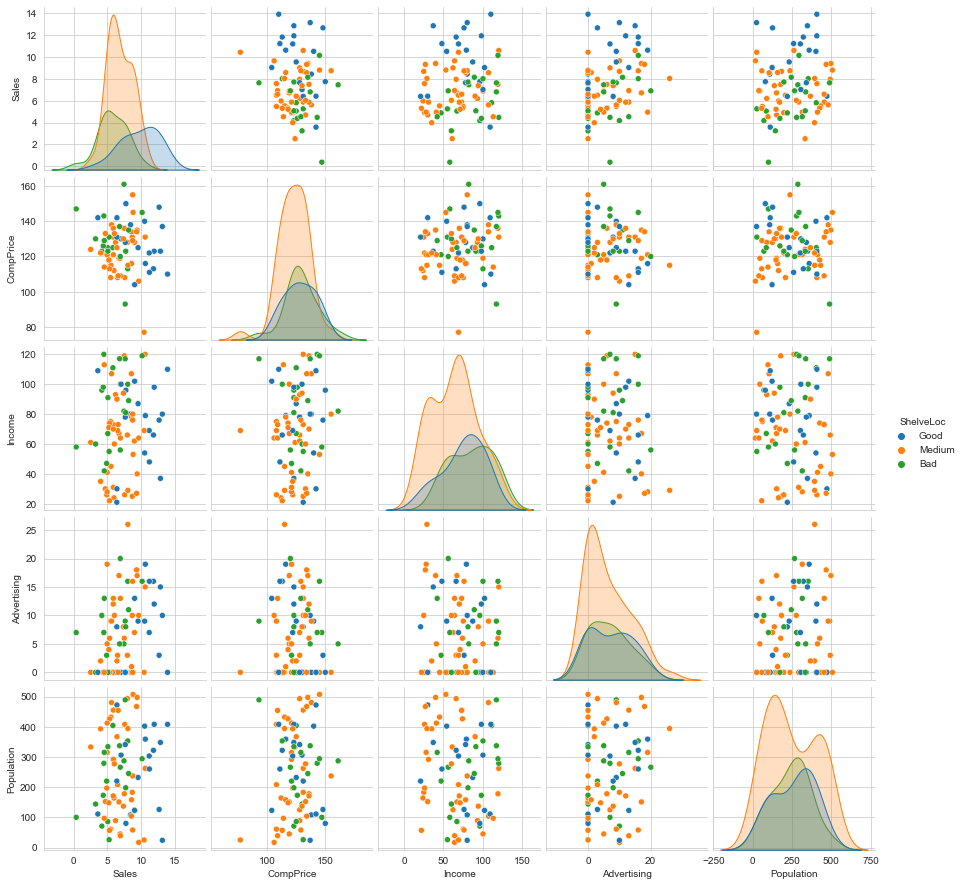

In [7]:
## One potential plot of interest is a pairplot
## https://seaborn.pydata.org/examples/scatterplot_matrix.html
sns.pairplot(car_train[['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'ShelveLoc']], hue='ShelveLoc')

plt.show()

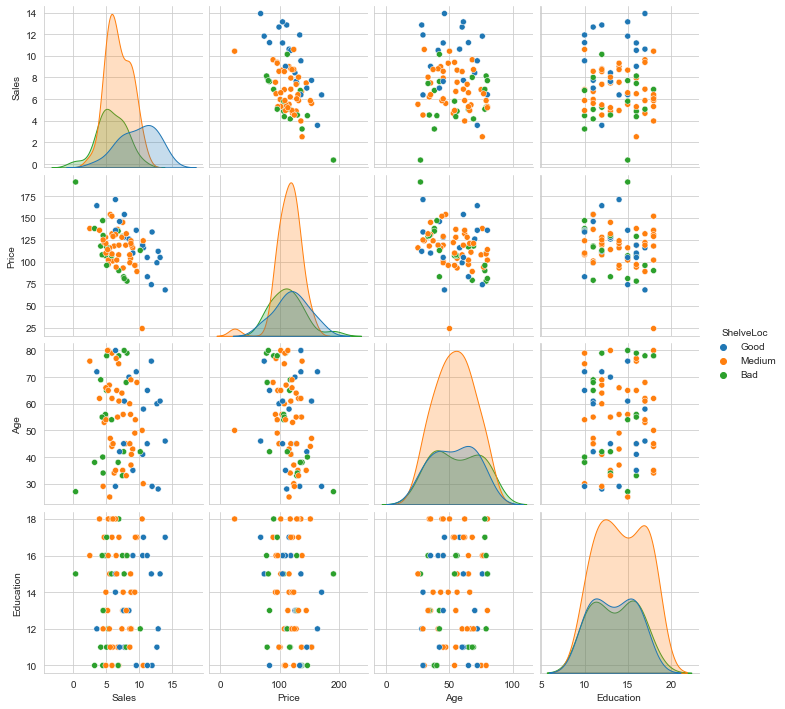

In [8]:
## One potential plot of interest is a pairplot
## https://seaborn.pydata.org/examples/scatterplot_matrix.html
sns.pairplot(car_train[['Sales', 'Price', 'Age', 'Education', 'ShelveLoc']], hue='ShelveLoc')

plt.show()

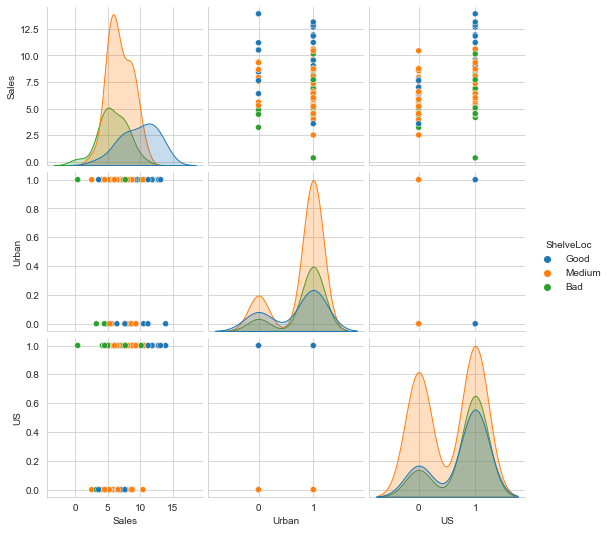

In [9]:
## One potential plot of interest is a pairplot
## https://seaborn.pydata.org/examples/scatterplot_matrix.html
sns.pairplot(car_train[['Sales', 'Urban', 'US', 'ShelveLoc']], hue='ShelveLoc')

plt.show()

From these plots it seems that the following variables may have some association with `Sales`:
- `Advertising`,
- `Population`,
- `Price`,
- `ShelveLoc` and
- `US`.

These would be good parameters to play around as a first step in modeling.

## Best subsets selection

The first feature selection algorithm we will examine is known as <i>best subsets selection</i>. This is a brute force algorithm that will look at every possible model from a set of features. For example if the features were: `CompPrice` and `Advertising`, best subsets selection would test all of the following models:

$$
\text{Sales} = E(\text{Sales}) + \epsilon
$$

$$
\text{Sales} = \beta_0 + \beta_1 \text{CompPrice} + \epsilon
$$

$$
\text{Sales} = \beta_0 + \beta_1 \text{Advertising} + \epsilon
$$

$$
\text{Sales} = \beta_0 + \beta_1 \text{CompPrice} + \beta_2 \text{Advertising} + \epsilon
$$

We will implement this with the following subset of features: `Age`, `CompPrice`, `Advertising`, `Price`, `Population`, `US` and  `ShelveLoc`. <i>Note, I chose a subset of features here because there are a fair amount of features to look at, and I want my code to run reasonably quickly. We will talk more about this after we implement the algorithm</i>.

In [10]:
## Import KFold
from sklearn.model_selection import KFold

## Import LinearRegression
from sklearn.linear_model import LinearRegression

In [11]:
## Make all potential feature combos
# This function was modified from stackexchange user hughdbrown 
# at this link, 
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

# This returns the power set of a set minus the empty set
def powerset(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
        
    return power_set[1:]

In [12]:
## demonstrate powerset
powerset(["CompPrice", "Advertising"])

[['CompPrice'], ['Advertising'], ['CompPrice', 'Advertising']]

In [13]:
## import mse
## https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
from sklearn.metrics import mean_squared_error

In [14]:
## Make kfold object
kfold = KFold(n_splits=5, 
              shuffle=True, 
              random_state = 5309)

In [15]:
## get all models we're interested in
models = powerset(["Age", "CompPrice", "Advertising", "Price", "Population", "US", "ShelveLoc"])

## This loop changes the "ShelveLoc" option into its dummy variable equivalent
for i in range(len(models)):
    if "ShelveLoc" in models[i]:
        models[i] = [feature for feature in models[i] if feature != "ShelveLoc"]
        models[i].extend(["ShelveLoc_Good", "ShelveLoc_Bad"])

## This is the baseline model
models.append("baseline")


## make empty mse holder
cv_mses = np.zeros((5, len(models)))



## loop through all splits
i = 0
for train_index, test_index in kfold.split(car_train):
    ## get train and holdout sets
    car_train_train = car_train.iloc[train_index]
    car_holdout = car_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            car_train_train_mean = car_train_train.Sales.mean()
            predict = car_train_train_mean * np.ones(len(car_holdout))
            cv_mses[i,j] = mean_squared_error(car_holdout.Sales, predict)
        else:
            ## make clone
            reg = LinearRegression(copy_X = True)
        
        
            ## fit clone
            reg.fit(car_train_train[model], car_train_train.Sales)
            predict = reg.predict(car_holdout[model])

            ## record mse
            cv_mses[i,j] = mean_squared_error(car_holdout.Sales, predict)
        j=j+1
    i=i+1  

In [16]:
## Which one had the smallest avg cv mse?
np.argmin(np.mean(cv_mses, axis=0))

110

In [17]:
## which model had lowest mean mse?
print("The model with lowest mean cv mse included the features", 
      models[np.argmin(np.mean(cv_mses, axis=0))],
      "and had an avg cv mse of",
      np.mean(cv_mses, axis=0)[np.argmin(np.mean(cv_mses, axis=0))])

The model with lowest mean cv mse included the features ['Age', 'CompPrice', 'Advertising', 'Price', 'US', 'ShelveLoc_Good', 'ShelveLoc_Bad'] and had an avg cv mse of 1.2663800213235579


In [20]:
np.mean(cv_mses, axis=0)[-1]

6.854057470703125

#### Getting greedy

Best subsets is not always the best approach because of the sheer number of models you may have to check. Suppose you are testing out $m$ possible features, then best subsets will have to fit and assess $2^m$ models. That gets out of hand quickly. Let's discuss two possible alternate approaches that may be faster because they are <i>greedy</i>, meaning that they make decisions based on what will most improve model performance in the very next step. Such approaches are called greedy because they only care about getting as much as possible in that step, sometimes at the cost of overall performance.

We will now describe, but not code up, <i>forwards selection</i> and <i>backwards selection</i>.


##### Forwards selection


Suppose you are interested in the performance of a regression model that may include any one of $m$ possible features.

- Step 0: Fit the baseline model, record the average cv mse

- Step 1: Fit each of the $m$ possible simple linear regression models and calculate their avg. cv mses:
    - if none of them outperform the baseline, you are done,
    - else, choose the one with lowest avg. cv mse, this is now your default model.
    
- Step $l$: Loop through each of the $m-l$ features not included in the default model, fit the regression model that includes them, calculate the avg. cv mse:
    - if none of them outperform the current default model, you are done,
    - else, choose the one with lowest avg. cv mse, this is now your default model.
    

##### Backwards selection

This approach is essentially the reverse of forwards selection, again suppose you have $m$ possible features.

- Step 0: Fit the linear regression model that includes all $m$ features, this is now your default model.

- Step 1: Fit each of the $m$ linear regression model that has removed exactly one of those $m$ features, calculate the resulting avg. cv mse:
    - if none of them outperform the default model, you are done,
    - else, choose the one with lowest avg. cv mse, this is now your default model.
    
- Step $l$: Loop through each of the $m-(l-1)$ features still included in the default model, fit the resulting regression model and record the avg. cv mse:
    - if none of these models outperform the default model, you are done,
    - else, choose the one with lowest avg. cv mse, this is now your default model.
    
Either approach will terminate in at most $m!$ steps.

## A lasso reminder

The other algorithmic approach we will touch on is lasso regression.

Recall from our Regularization that lasso can be used for feature selection by slowly increasing the value of the hyperparameter $\alpha$ and observing the persistence of the coefficients (i.e. which coefficients stay above $0$ the longest?). 

We will now demonstrate this for the `carseats` data set and all of the possible features.

In [21]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [22]:
alphas = [0.000001,.00001,.0001,.001,.01,.1,.25,.5,.75,1,5,10,25,50,100,1000,10000]
features = ['CompPrice', 'Income', 'Advertising', 'Population', 'Price',
               'Age', 'Education', 'Urban', 'US', 'ShelveLoc_Good', 'ShelveLoc_Bad']

## make coefficient holder
coefs = np.zeros((len(alphas), len(features)))

## scale quantitative variables
car_train_array = car_train[features].to_numpy()

scaler = StandardScaler()

## These are the features that need to be scaled
## 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education'
scale_columns = [0,1,2,3,4,5,6]
car_train_array_scaled = car_train_array.copy()
car_train_array_scaled[:,scale_columns] = scaler.fit_transform(car_train_array_scaled[:,scale_columns])


## Loop through alphas
for i in range(len(alphas)):
    ## make lasso model
    lasso = Lasso(alpha=alphas[i], max_iter=10000000)
    
    
    ## fit model
    lasso.fit(car_train_array_scaled, car_train.Sales.values)
    
    ## record coefs
    coefs[i,:] = lasso.coef_
    

In [23]:
## use dataframe to look at coefs

pd.DataFrame(coefs, index=alphas, columns=features)


,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Good,ShelveLoc_Bad
0.000001,1.023234,0.388901,0.623973,-0.023427,-2.263429,-0.718449,-0.248514,0.068788,0.523449,2.549877,-2.156313
0.000010,1.023212,0.388913,0.624014,-0.023426,-2.263395,-0.718433,-0.248504,0.068705,0.523352,2.549843,-2.156247
0.000100,1.022916,0.388972,0.624268,-0.023393,-2.263017,-0.718264,-0.248402,0.067931,0.522623,2.549526,-2.155552
0.001000,1.019594,0.389123,0.625443,-0.022814,-2.259004,-0.716543,-0.247453,0.060666,0.517474,2.546405,-2.148544
0.010000,0.987176,0.389238,0.635769,-0.015845,-2.219569,-0.699688,-0.237945,0.000000,0.467381,2.516888,-2.078389
0.100000,0.718391,0.309956,0.693190,0.000000,-1.875818,-0.573609,-0.129477,-0.000000,0.000000,2.324382,-1.366074
0.250000,0.233397,0.112610,0.531734,0.000000,-1.287787,-0.364968,-0.000000,-0.000000,0.000000,1.911973,-0.296599
0.500000,0.000000,0.000000,0.322944,0.000000,-0.718104,-0.001605,-0.000000,-0.000000,0.000000,0.618346,-0.000000
0.750000,0.000000,0.000000,0.098326,0.000000,-0.453317,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000
1.000000,-0.000000,0.000000,0.000000,0.000000,-0.208194,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000


This output suggest that we should keep `Price` for sure, then `ShelveLoc`, `Age` and `Advertising`.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)